In [1]:
from ipsl_dcpp.model.ipsl_dataset import IPSL_DCPP
import torch
import lightning as pl
from ipsl_dcpp.model.pangu import PanguWeather
from hydra import compose, initialize
from omegaconf import OmegaConf

import hydra
import os
work_dir = os.environ['WORK']
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
pl.seed_everything(cfg.experiment.seed)
train = hydra.utils.instantiate(
    cfg.experiment.train_dataset,
    generate_statistics=False,
    surface_variables=cfg.experiment.surface_variables,
    depth_variables=cfg.experiment.depth_variables,
    delta=False
)

train_dataloader = torch.utils.data.DataLoader(
    train,
    batch_size=1,
    shuffle=True,
    num_workers=1
)

#batch = next(iter(train_dataloader))
model = hydra.utils.instantiate(
    cfg.experiment.module,
    backbone=hydra.utils.instantiate(
        cfg.experiment.backbone,
    ),
    dataset=train_dataloader.dataset
)
trainer = pl.Trainer(
    max_epochs=cfg.experiment.max_epochs,
    enable_checkpointing=True,
    log_every_n_steps=1,
   # max_steps=cfg.experiment.max_steps if not cfg.debug else 10,
    #precision="16-mixed",
    #precision='32',
    profiler='simple' if cfg.debug else None,
   # devices=cfg.experiment.num_gpus,
   # strategy='ddp_find_unused_parameters_true',
    #limit_train_batches=0.01 if cfg.debug else 1
    #limit_val_batches=0.01 if cfg.debug else 1,
    fast_dev_run=1
)

model = hydra.utils.instantiate(
    cfg.experiment.module,
    backbone=hydra.utils.instantiate(
        cfg.experiment.backbone,
    ),
    dataset=train_dataloader.dataset
)


/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[rank: 0] Seed set to 0
/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67

In [ ]:
trainer.fit(
    model=model,
    train_dataloaders=train_dataloader)
trainer.logged_metrics

/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name     | Type         | Params
------------------------------------------
0 | backbone | PanguWeather | 79.4 M
------------------------------------------
79.4 M    Trainable params
0         Non-trainable params
79.4 M    Total params
317.422   Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


configure optimizers


/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] (12, 91, 143, 144)
(12, 91, 143, 144)
(12, 91, 143, 144)


In [54]:
from ipsl_dcpp.model.embedding import PatchEmbed2D,PatchEmbed3D
import torch.nn as nn
surface1 = batch['state_surface'].squeeze(-4)
# print('surface',surface)
# print('surface non nan',torch.nonzero(torch.isnan(surface.view(-1))))
# upper_air = batch['state_level']
depth = batch['state_depth'].squeeze(-5)
patchembed2d = PatchEmbed2D(
            img_size=(143, 144),
            patch_size=(2,2),
            in_chans=91,  
            embed_dim=192,
        )
depth_patchembed3d = PatchEmbed3D(
            img_size=(11, 143, 144),
            patch_size=(2,2,2),
            in_chans=3,
            embed_dim=192
        )
surface = patchembed2d(surface1)
depth = depth_patchembed3d(depth)

x1 = torch.concat([surface.unsqueeze(2),depth], dim=2)
B, C, Pl, Lat, Lon = x1.shape

x = x1.reshape(B, C, -1).transpose(1, 2)
norm1 = nn.LayerNorm(192,eps=1e-10)
normed = norm1(x)

In [4]:
batch['state_surface'].shape

torch.Size([1, 1, 91, 143, 144])

In [ ]:
for i in range(91):
    index = batch['state_surface'][0][0][i].argmax()
    print(i,index,batch['state_surface'][0][0][i][index//143][index%144])
    print(train.surface_variables[i])

In [102]:
[index // 143, index % 144]


[tensor(49), tensor(50)]

In [117]:
batch['state_surface'][0][0][31][833//143]

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0

In [93]:
batch['state_surface'][0][0]

torch.Size([91, 143, 144])

In [74]:
batch['state_surface'][0][0][5][109]

tensor([ -3.9560,  -3.2934,  -2.9705,  -1.8457,  -0.6251,  -0.8850,  -1.2212,
         -5.8131,  -5.0001,  -5.9656,  -5.9326,  -4.7875,  -4.5414,  -4.5636,
         -4.0587,  -4.2248,  -3.6446,  -3.7291,  -3.9231,  -3.4146,  -3.7299,
         -3.7629,  -4.1396,  -3.9791,  -3.4727,  -3.5972,  -3.7932,  -3.9216,
         -3.2879,  -3.3282,  -2.9743,  -3.0626,  -2.5901,  -3.1968,  -3.7405,
         -5.1373,  -4.2936,  -3.0075,  -4.3055,  -3.7725,  -5.6545,  -5.6694,
         -3.9618,  -6.7538,  -5.9902,  -4.7205,  -3.8625,  -2.8799,  -7.7351,
         -9.8668,  -5.1511, -12.5469,  -5.7022, -16.5808, -16.9069,  -2.0287,
         -2.1988,  -2.5188,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.00

In [87]:
torch.topk(batch['state_surface'][0][0],k=1,dim=1,sorted=True).values

tensor([[[1.0452, 1.0533, 1.0701,  ..., 1.1582, 1.2428, 1.0696]],

        [[1.0390, 1.0220, 0.8872,  ..., 1.0628, 1.0266, 0.9178]],

        [[1.0827, 0.0000, 1.5594,  ..., 2.1332, 2.2147, 1.7459]],

        ...,

        [[3.1013, 0.6784, 2.8618,  ..., 3.8106, 0.5284, 1.7984]],

        [[0.0000, 0.0000, 1.2839,  ..., 3.3696, 0.1112, 0.1201]],

        [[4.0489, 0.6784, 2.7865,  ..., 3.6582, 0.5860, 1.9122]]])

In [48]:
x1[0,0,0,68,:]

tensor([-1.1056e+02, -1.1022e+02, -1.0977e+02, -1.0957e+02, -1.0944e+02,
        -1.0968e+02, -1.0991e+02, -1.1010e+02, -1.1040e+02, -1.1056e+02,
        -1.1048e+02, -1.1048e+02, -1.1052e+02, -1.1063e+02, -1.1091e+02,
        -1.1109e+02, -1.1120e+02, -1.1133e+02, -1.1133e+02, -1.1117e+02,
        -1.1108e+02, -1.1103e+02, -1.1082e+02, -1.1092e+02, -1.1121e+02,
        -1.1149e+02, -1.1178e+02, -1.1192e+02, -1.1202e+02, -1.1219e+02,
        -1.1237e+02, -1.1255e+02, -1.1273e+02, -1.1294e+02, -1.1303e+02,
        -1.1300e+02, -1.1294e+02, -1.1272e+02, -1.1262e+02, -1.1248e+02,
        -1.1235e+02, -1.1244e+02, -1.1242e+02, -1.1265e+02, -1.1291e+02,
        -1.1294e+02, -1.1264e+02, -1.1264e+02, -1.1271e+02, -1.1279e+02,
        -1.1283e+02, -1.1269e+02, -1.1262e+02, -1.1219e+02, -1.1202e+02,
         8.8132e+36, -1.3976e+37, -7.4173e+36, -6.3694e+36,  2.5712e+36,
        -1.1179e+02, -1.1253e+02, -1.1227e+02,  1.9869e+36, -9.7364e+36,
        -1.0855e+02,  8.6519e+35, -1.1450e+02, -1.1

In [8]:
sum(torch.isnan(normed).flatten())

tensor(51456)

In [21]:
x[0,519,:]

tensor([-1.1735e+37,  4.1177e+36, -2.6683e+35,  1.5196e+37, -7.5233e+36,
        -5.0266e+36, -1.7038e+37,  1.4490e+37,  7.0359e+36, -1.7061e+37,
        -1.8209e+36, -1.7387e+37, -1.5412e+37,  7.0993e+36, -1.2876e+37,
         1.3759e+37, -1.6373e+37, -1.8289e+36,  1.4457e+37, -7.2995e+36,
         1.2972e+37, -6.9500e+36,  1.1064e+37,  8.5500e+36,  6.7282e+36,
         1.5024e+36, -6.8020e+36,  5.4937e+36, -1.5995e+37, -1.5762e+37,
        -1.5266e+37,  9.9249e+36, -1.6098e+36,  1.1959e+37,  5.2433e+36,
         1.5290e+37, -7.2467e+36,  1.0674e+37,  4.4249e+36,  4.5540e+36,
         2.4652e+36, -4.1767e+36,  1.3556e+37, -1.2295e+37, -1.1291e+37,
         1.0693e+37, -1.2945e+37, -6.1337e+36, -6.3069e+36,  8.0070e+36,
         1.2329e+36,  6.0152e+36,  9.7537e+36, -1.7626e+37,  3.4608e+36,
         2.2333e+36,  1.6060e+37,  1.5599e+36,  1.3936e+37,  1.3858e+37,
         9.0798e+36, -8.8403e+36, -7.8995e+36,  1.0006e+37,  1.5531e+37,
        -9.7528e+36, -1.4275e+37,  3.8806e+36,  1.0

In [ ]:
for i in range(36288):
    if(sum(torch.isnan(normed)[0][i]) > 0):
        print(i)

In [ ]:
import torch.nn

In [8]:
assert sum(torch.isnan(batch['state_depth']).flatten()) == 0

In [6]:
import numpy as np
import os 
work = os.environ['WORK']
delta_std = np.expand_dims(np.load(f'{work}/ipsl_dcpp/ipsl_dcpp/data/surface_delta_std.npy'),axis=(0))
delta_depth = np.expand_dims(np.load(f'{work}/ipsl_dcpp/ipsl_dcpp/data/depth_delta_std.npy'),axis=(0))

surface_stds = np.expand_dims(np.load(f'{work}/ipsl_dcpp/ipsl_dcpp/data/climatology_surface_stds.npy'),axis=0)


In [19]:
surface_mask = (delta_std!= 0)


In [8]:
import torch 
import numpy as np
myTensor = np.array([1,np.nan,2,np.nan])
np.nonzero(np.isnan(myTensor))[0]

array([1, 3])

In [5]:
import xarray as xr
obs = xr.open_dataset(train.files[0])


In [9]:
obs.isel(time=0).time.dt.

In [2]:
import numpy as np
import os 
work = os.environ['WORK']

In [2]:
x = np.array([1,2,3])

In [4]:
np.expand_dims(x,(-1,-2))

array([[[1]],

       [[2]],

       [[3]]])

In [3]:
stds =  np.load(f'{work}/ipsl_dcpp/ipsl_dcpp/data/climatology_surface_stds.npy')
means = np.load(f'{work}/ipsl_dcpp/ipsl_dcpp/data/climatology_surface_means.npy')
surface_delta = np.load('../data/surface_delta_std.npy')

array([3.59935616e-03, 9.71417688e-03, 4.73997705e-02, 2.33941767e-02,
       9.70278308e-03, 8.13741703e-03, 5.57109108e-03,            nan,
                  nan,            nan,            nan, 3.81821766e-02,
       1.07380524e-01, 1.02937691e-01, 2.46918220e-02, 2.77504921e-02,
       1.49345482e-02, 3.77774946e-02, 3.17898840e-02, 5.36246896e-02,
       6.45342395e-02, 1.03514288e-02, 1.17617399e-02, 1.21959457e-02,
       1.14165917e-02, 1.00698452e-02, 3.75035754e-03, 8.30689631e-03,
       2.73483712e-02, 5.31832993e-05, 6.25597822e-05, 5.71822920e-06,
       3.08581907e-03, 1.74379535e-03, 2.98788772e-12, 2.05636316e-05,
       3.35400109e-05, 1.78947404e-03, 1.78118411e-03, 4.29713260e-03,
       7.53296539e-03, 4.70277593e-02, 4.26210426e-02, 7.19374046e-02,
       8.38966444e-02, 1.19122304e-01, 8.99330601e-02, 1.13327734e-01,
       9.52009186e-02,            nan,            nan, 1.27144650e-01,
       1.84547052e-01,            nan, 1.69930145e-01, 1.55258432e-01,
      

In [9]:
for i in range(12):
    print(np.isnan(means[i]).flatten().sum() / len(means[i].flatten()))

0.3591120418043495
0.3591120418043495
0.3591120418043495
0.3591120418043495
0.3591120418043495
0.3591120418043495
0.3591120418043495
0.3591120418043495
0.3591120418043495
0.3591120418043495
0.3591120418043495
0.3591120418043495


In [ ]:
import xarray as xr
import os
import torch
from ipsl_dcpp.model.ipsl_dataset import IPSL_DCPP
import hydra
import os
import numpy as np
from hydra import compose, initialize

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
work_dir = os.environ['WORK']
store_dir = os.environ['STORE'] 

#year = 1960
#variation = 1
#Amon =  xr.open_mfdataset(f'{store_dir}/s{year}-r{variation}i1p1f1/Amon/*.nc',compat='minimal')
#get climatology over train period for a year period
#train = IPSL_DCPP('train',generate_statistics=True,lead_time_months=1)
train =  IPSL_DCPP('train',1,generate_statistics=True,
              delta=False,
              surface_variables=cfg.experiment.surface_variables,
              depth_variables=cfg.experiment.depth_variables)
surface_means_out = []
train_dataloader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False,num_workers=1)
   
surface_stds_out = []
depth_means_out = []
depth_stds_out = []
iter_batch = iter(train_dataloader)
for count in range(10):
    print(count)
    surface_means = []
    surface_stds = []
    depth_means = []
    depth_stds = []
    for _ in range(24):
        batch = next(iter_batch) 
        surface_means.append(batch['state_surface'].squeeze())
        surface_stds.append(batch['state_surface'].squeeze())
        depth_means.append(batch['state_depth'].squeeze())
        depth_stds.append(batch['state_depth'].squeeze())
        

    surface_means_out.append(np.nanmean(np.stack(surface_means).reshape(-1,12,91,143,144),axis=0))
    surface_stds_out.append(np.nanstd(np.stack(surface_stds).reshape(-1,12,91,143,144),axis=0))
    depth_means_out.append(np.nanmean(np.stack(depth_means).reshape(-1,12,3,11,143,144),axis=0))
    depth_stds_out.append(np.nanstd(np.stack(depth_stds).reshape(-1,12,3,11,143,144),axis=0))
    break


In [ ]:
np.nanmean(np.stack(surface_means,dtype=np.float16).reshape(-1,12,91,143,144),axis=0)

In [52]:
means = np.nanmean(np.stack(surface_means).reshape(-1,12,91,143,144)[:,:,:,:,:],axis=0)

/tmp/ipykernel_387448/761602154.py:1: RuntimeWarning: Mean of empty slice
  means = np.nanmean(np.stack(surface_means).reshape(-1,12,91,143,144)[:,:,:,:,:],axis=0)


In [57]:
np.nanmean(means[0,:])

319300300.0

In [ ]:
np.nanmean(np.stack(surface_means).reshape(-1,12,91,143,144),axis=0,dtype=np.float32)

In [3]:
import torch
torch.Tensor([1,2,3]).half()

tensor([1., 2., 3.], dtype=torch.float16)

In [ ]:
train.files

In [2]:
obs = xr.open_dataset(train.files[10])


In [3]:
train.surface_variables

['c3PftFrac', 'c4PftFrac', 'cLeaf', 'cLitter', 'cProduct', 'cRoot', 'cVeg', 'mrsos', 'evspsblsoi', 'evspsblveg', 'fLitterSoil', 'fVegLitter', 'lai', 'mrfso', 'mrro', 'mrros', 'mrso', 'prveg', 'rGrowth', 'rMaint', 'ra', 'rh', 'tran', 'ci', 'clwvi', 'evspsbl', 'hfls', 'hfss', 'hurs', 'huss', 'pr', 'prc', 'prsn', 'prw', 'ps', 'psl', 'rlds', 'rldscs', 'rlus', 'rlut', 'rlutcs', 'rsds', 'rsdscs', 'rsdt', 'rsus', 'rsuscs', 'rsut', 'rsutcs', 'rtmt', 'sfcWind', 'tas', 'tasmax', 'tasmin', 'tauu', 'tauv', 'ts', 'uas', 'vas', 'cLand', 'cMisc', 'cOther', 'cSoil', 'cStem', 'cVegGrass', 'cVegTree', 'cWood', 'evspsblpot', 'fProductDecomp', 'intuadse', 'intuaw', 'intvadse', 'intvaw', 'mrlso', 'mrtws', 'prhmax', 'raGrass', 'raTree', 'rhGrass', 'rhLitter', 'rhSoil', 'rhTree', 'rls', 'rss', 'sconcdust', 'sconcso4', 'sconcss', 'sfcWindmax', 'npp', 'nbp', 'gpp', 'nep']

In [6]:
arr = obs[list(train.surface_variables)].isel(time=0).to_array()

In [12]:
np.isnan(arr.to_numpy()).flatten().sum() / len(arr.to_numpy().flatten())

0.3591120418043495

In [13]:
arr = arr.to_numpy()

In [66]:
batch['state_surface']

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [76]:
batch['state_surface'].squeeze()[-2,:,:]

tensor(-0.2738)

In [2]:
import numpy as np
old_depth_means = np.load('../data/climatology_surface_means.npy')

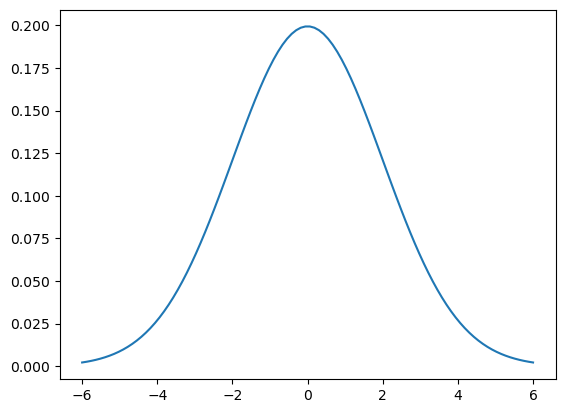

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 4
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [24]:
atmos_forcings = np.load('../data/atmos_forcings.npy')

In [28]:
forcings_means = atmos_forcings.mean(axis=1)
forcings_stds = atmos_forcings.std(axis=1)
